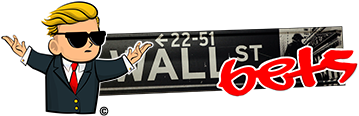

# Discussion progression forecasting

## Upgraded predictions

### Combine timeseries as attributes with checkpoint IV dataset

In [ ]:
# Prepare data for prediction
df = pd.read_pickle('final_df_with_timestamp_epoch.pkl')
print(df.shape)
df.head(2)

(19413, 167)


,body_amc,body_buy,body_chars_number,body_chars_per_word,body_compani,body_day,body_emoji_number,body_fuck,body_fund,body_gme,body_hashtags_number,body_hold,body_know,body_like,body_links_number,body_make,body_market,body_money,body_numbers_number,body_peopl,body_price,body_robinhood,body_sell,body_share,body_short,body_stock,body_thi,body_think,body_time,body_trade,body_want,body_words_number,color_1_h,color_1_s,color_1_v,color_2_h,color_2_s,color_2_v,color_3_h,color_3_s,...,title_hold,title_let,title_like,title_market,title_moon,title_nok,title_numbers_number,title_retard,title_robinhood,title_sell,title_share,title_short,title_stock,title_stop,title_thi,title_time,title_today,title_trade,title_words_number,body_sentiment_Negative,body_sentiment_Neutral,body_sentiment_Positive,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,title_sentiment_Negative,title_sentiment_Neutral,title_sentiment_Positive,type_deleted_image,type_image,type_other,type_self,type_video,timestamp_unix,id,timestamp_epoch
0,0.0,0.0,0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,97.745155,0.002452,0.963575,116.076149,0.000266,0.999419,78.905243,0.010683,...,0.779558,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2021-01-29 23:12:20+09:00,l87ci6,1611929540
1,0.0,0.0,806,5.597222,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,2021-02-04 05:17:59+09:00,lc8dnh,1612383479


In [ ]:
# Timeseries based on default: number of comments
df_ts = pd.read_pickle('time_series.pkl')
# df_ts = df_ts[["post_id", "1_hour"]]
print(df_ts.shape)
df_ts.head(2)

(14812, 25)


,post_id,1_hour,2_hour,3_hour,4_hour,5_hour,6_hour,7_hour,8_hour,9_hour,10_hour,11_hour,12_hour,13_hour,14_hour,15_hour,16_hour,17_hour,18_hour,19_hour,20_hour,21_hour,22_hour,23_hour,24_hour
0,l0wyi2,18,6,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,l0x0s4,37,6,9,11,1,0,3,0,0,0,0,0,0,1,0,0,2,0,0,0,1,0,1,0


In [ ]:
# Add data from timeseries
df_final = pd.concat([df.set_index('id'), df_ts.set_index('post_id')], axis=1, join='inner').reset_index()
print(df_final.shape)
df_final.to_pickle('posts_with_timeseries.pkl')
df_final.head(2)

(14812, 168)


,index,body_amc,body_buy,body_chars_number,body_chars_per_word,body_compani,body_day,body_emoji_number,body_fuck,body_fund,body_gme,body_hashtags_number,body_hold,body_know,body_like,body_links_number,body_make,body_market,body_money,body_numbers_number,body_peopl,body_price,body_robinhood,body_sell,body_share,body_short,body_stock,body_thi,body_think,body_time,body_trade,body_want,body_words_number,color_1_h,color_1_s,color_1_v,color_2_h,color_2_s,color_2_v,color_3_h,...,title_hold,title_let,title_like,title_market,title_moon,title_nok,title_numbers_number,title_retard,title_robinhood,title_sell,title_share,title_short,title_stock,title_stop,title_thi,title_time,title_today,title_trade,title_words_number,body_sentiment_Negative,body_sentiment_Neutral,body_sentiment_Positive,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,title_sentiment_Negative,title_sentiment_Neutral,title_sentiment_Positive,type_deleted_image,type_image,type_other,type_self,type_video,timestamp_unix,timestamp_epoch,1_hour
0,l87ci6,0.0,0.0,0,0.000000,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,97.745155,0.002452,0.963575,116.076149,0.000266,0.999419,78.905243,...,0.779558,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,2021-01-29 23:12:20+09:00,1611929540,69
1,l4pdma,0.0,0.0,47,4.272727,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,2021-01-25 14:54:30+09:00,1611554070,0


### Convenience functions for training/testing model and feature importance evaluation

In [ ]:
# available: 1h, 2h, 5h, 12h, blank
def popularity_with_timeseries(suffix=""):
  df = pd.read_pickle(f'posts_with_timeseries{suffix}.pkl') 
  X = df.drop(['score', 'timestamp_unix', 'timestamp_epoch', 'index'], axis=1)
  y = df['score']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

  model = CatBoostRegressor(loss_function='MAE', early_stopping_rounds=10, silent=True)
  model.fit(X_train,y_train)

  y_pred = model.predict(X_test)
  print("Previous MAE: ")
  print(2008.1155938271672)
  print("Current MAE: ")
  print(mean_absolute_error(y_true=y_test,y_pred=y_pred))
  print()
  print("Sample predictions (test set):")
  for truth, pred_sample in list(zip(y_test, y_pred))[0:25]:
    print(truth, " ", int(pred_sample))
  return model

def get_feature_importance(model):
  import matplotlib.pyplot as plt
  plt.rcParams["font.family"] = "monospace"

  df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True)[0:35])

  # 🚀

  plt.figure(figsize=(16, 9))
  feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
  plt.title('features importance')
  plt.show()

### Prediction with information about comments from **n** first hours

#### 1 hour

In [ ]:
model_n = popularity_with_timeseries("1h")

Previous MAE: 
2008.1155938271672
Current MAE: 
2287.1225681894175

Sample predictions (test set):
8712   1320
105   55
6   6
88   11
7   8
97   111
21   36
3   22
59   49
63   218
20   26
30   16
389   318
21283   904
521   341
72   115
501   458
107   172
250   258
0   18
51   62
151   287
32   37
246   154
112   244


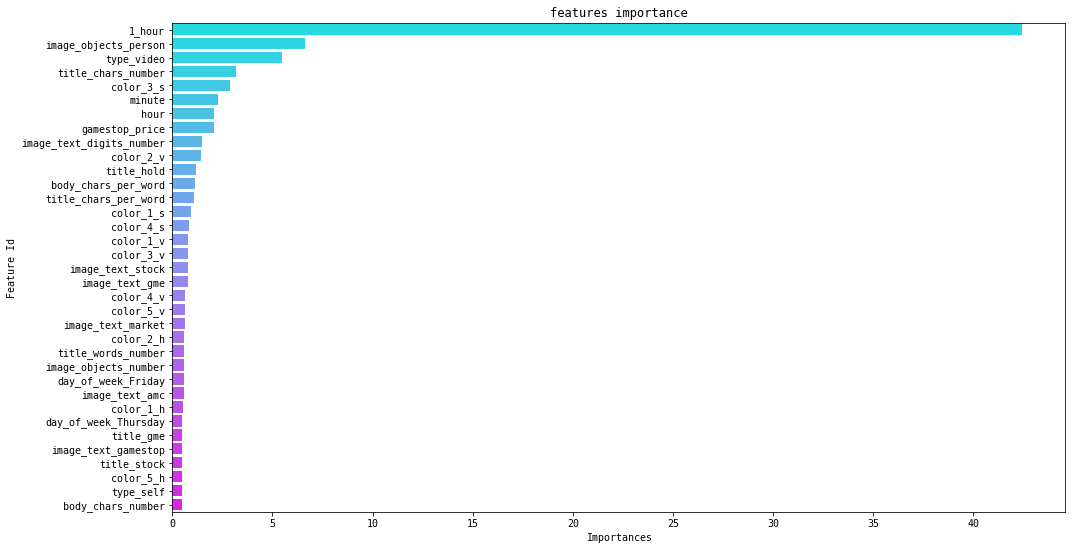

In [ ]:
get_feature_importance(model_n)

####2 hours

In [ ]:
model_n = popularity_with_timeseries("2h")

Previous MAE: 
2008.1155938271672
Current MAE: 
1460.6891356521585

Sample predictions (test set):
8712   4305
105   66
6   5
88   33
7   5
97   76
21   22
3   26
59   42
63   182
20   35
30   61
389   401
21283   10146
521   251
72   117
501   806
107   179
250   279
0   17
51   46
151   156
32   37
246   169
112   262


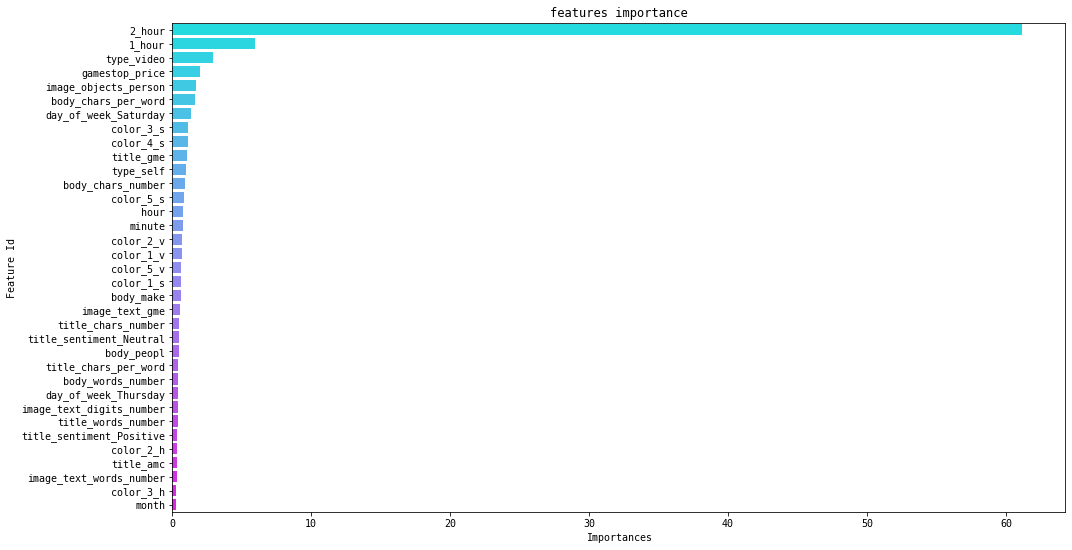

In [ ]:
get_feature_importance(model_n)

#### 5 hours

In [ ]:
model_n = popularity_with_timeseries("5h")

Previous MAE: 
2008.1155938271672
Current MAE: 
1087.4336765684986

Sample predictions (test set):
8712   6857
105   73
6   5
88   37
7   8
97   109
21   16
3   22
59   49
63   214
20   31
30   47
389   417
21283   10563
521   290
72   105
501   633
107   172
250   525
0   18
51   48
151   122
32   25
246   147
112   215


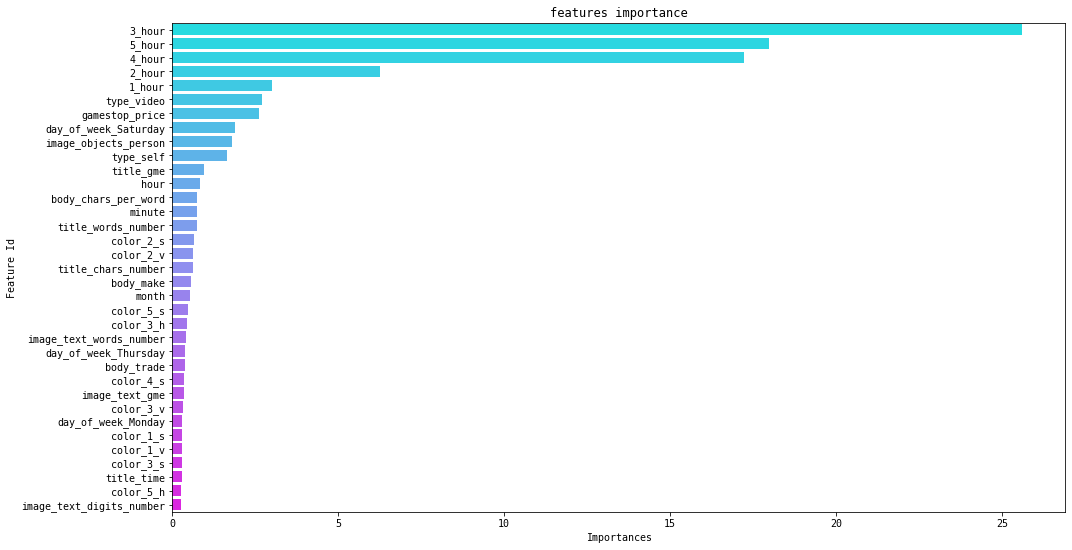

In [ ]:
get_feature_importance(model_n)

####12 hours

In [ ]:
model_n = popularity_with_timeseries("12h")

Previous MAE: 
2008.1155938271672
Current MAE: 
1049.715221904707

Sample predictions (test set):
8712   5724
105   74
6   4
88   66
7   7
97   -64
21   -4
3   23
59   53
63   192
20   41
30   58
389   575
21283   13833
521   329
72   146
501   694
107   181
250   218
0   16
51   53
151   177
32   36
246   166
112   415


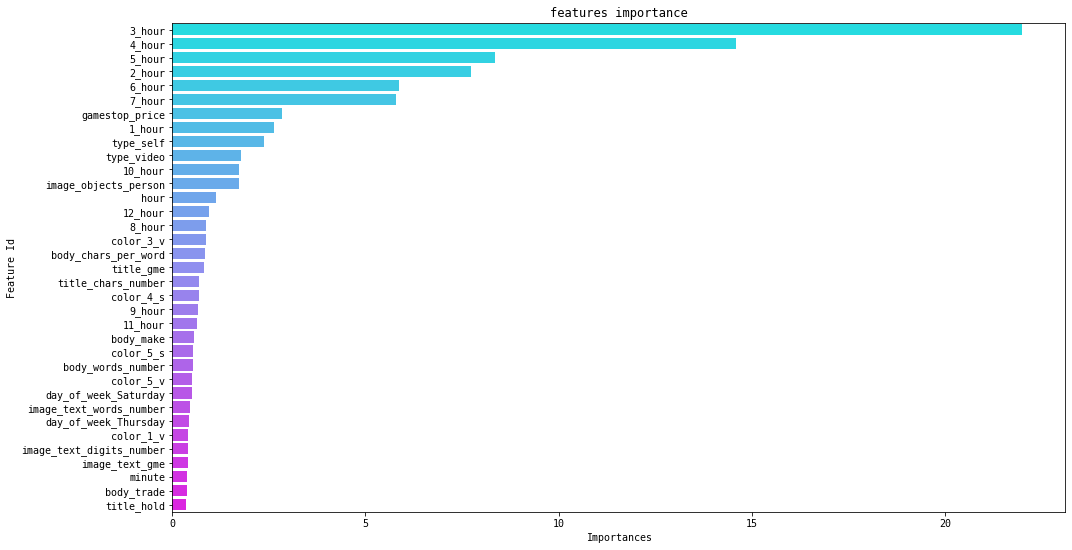

In [ ]:
get_feature_importance(model_n)

#### 24 hours

In [ ]:
model_n = popularity_with_timeseries()

Previous MAE: 
2008.1155938271672
Current MAE: 
1059.9566937811023

Sample predictions (test set):
8712   5918
105   67
6   3
88   44
7   4
97   128
21   25
3   24
59   46
63   213
20   40
30   45
389   384
21283   10439
521   354
72   134
501   750
107   160
250   306
0   16
51   52
151   173
32   37
246   209
112   255


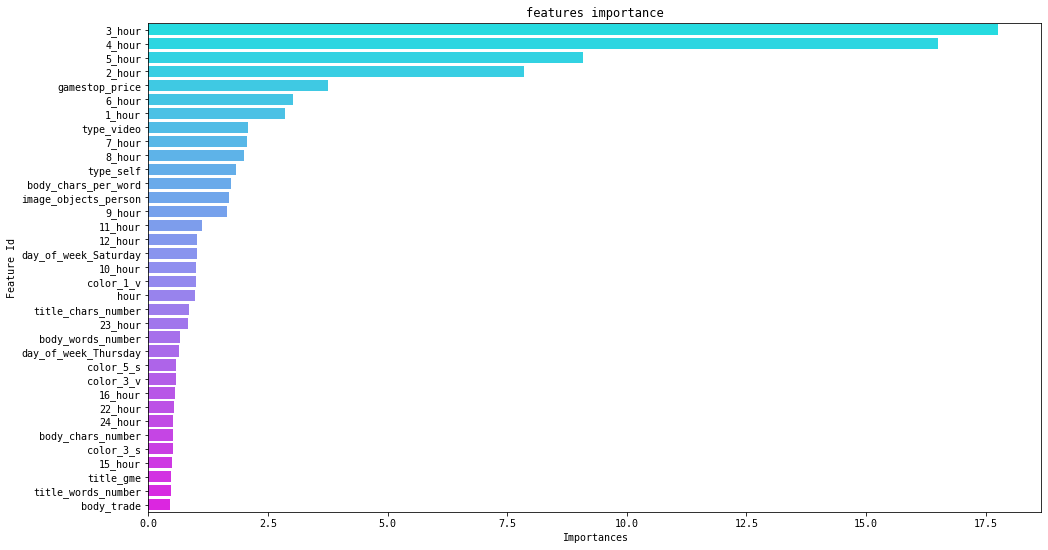

In [ ]:
get_feature_importance(model_n)

## Discussion progression forecasting model

### Wrong aproach with time series models (Prophet)

In [ ]:
df = pd.read_pickle('time_series_minutes.pkl')

post_id = 'l7tu52' #6756 comments

df_post = df.loc[df['post_id'] == post_id]
df_post = df_post.drop(columns='post_id')

df = df_post.T
df.columns = ['y']
df = df.reset_index(drop=True)
df['ds'] = pd.to_datetime(df.index * 60 * 10, unit='s')
df.head(3)

,y,ds
0,5613,1970-01-01 00:00:00
1,7281,1970-01-01 00:10:00
2,7526,1970-01-01 00:20:00


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.


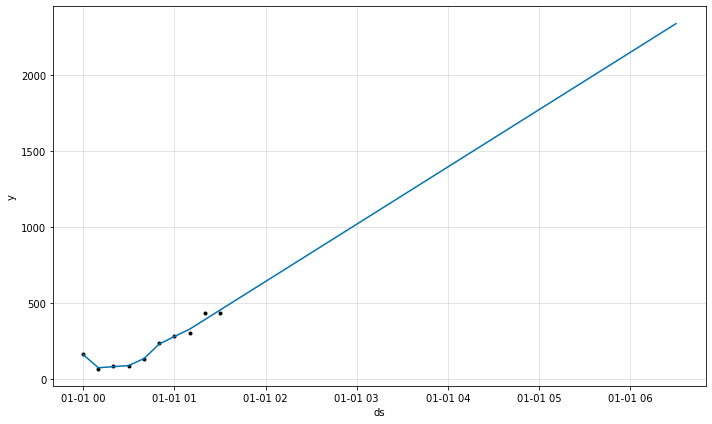

In [ ]:
m = Prophet(changepoint_prior_scale=3)
m.fit(df.head(10))

future = m.make_future_dataframe(periods=300, freq='min')

forecast = m.predict(future)

fig = m.plot(forecast, uncertainty=False)

### Correct approach with time window and regression

In [ ]:
df = pd.read_pickle('time_series_minutes.pkl')

results = []

window = 6

for index, row in df.iterrows():
  post_id = row["post_id"]
  del row["post_id"]

  for index, key in enumerate(row.keys(), 1):
    if index >= window:
      result = {}
      result['post_id'] = post_id
      result['index'] = index
      for t in range(0, window):
        key = f"t-{t}"
        time = index-t
        value = row[f"{time}0_minute"]
        result[key] = value
      results.append(result)

df = pd.DataFrame(results)
df.to_pickle('time_series_minutes_window.pkl')
df.head(3)


,post_id,index,t-0,t-1,t-2,t-3,t-4,t-5
0,l0wyi2,6,2,2,2,2,2,8
1,l0wyi2,7,0,2,2,2,2,2
2,l0wyi2,8,1,0,2,2,2,2


In [ ]:
df.describe()

,index,t-0,t-1,t-2,t-3,t-4,t-5
count,2.044056e+06,2.044056e+06,2.044056e+06,2.044056e+06,2.044056e+06,2.044056e+06,2.044056e+06
mean,7.450000e+01,2.096354e+00,2.190854e+00,2.290940e+00,2.402266e+00,2.531540e+00,2.718948e+00
std,3.983613e+01,6.184960e+01,6.412677e+01,6.646015e+01,6.899718e+01,7.150036e+01,7.319060e+01
min,6.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,7.450000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.090000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.430000e+02,1.061900e+04,1.061900e+04,1.061900e+04,1.061900e+04,1.186400e+04,1.186400e+04


In [ ]:
df = pd.read_pickle('time_series_minutes_window.pkl')

X = df.drop(['post_id', 't-0'], axis=1)
y = df['t-0']

models = {
    'LinearRegression': LinearRegression(),
    'ElasticNet': ElasticNet(random_state=0),
    'Ridge': Ridge(random_state=0),
    'Lasso': Lasso(random_state=0),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=0),
    'XGBRegressor': XGBRegressor(early_stopping_rounds=10),
    'CatBoostRegressor': CatBoostRegressor(loss_function='MAE', early_stopping_rounds=10),
    'RandomForestRegressor': RandomForestRegressor(random_state=0),
    'MLPRegressor': MLPRegressor(random_state=0)
}

params = {
    'ElasticNet': {'model__max_iter': [500, 1000]},
    'Ridge': {'model__max_iter': [500, 1000]},
    'Lasso': {'model__max_iter': [500, 1000]},
    'RandomForestRegressor': {'model__n_estimators': [50, 100, 200]},
    'DecisionTreeRegressor': {'model__max_depth': [None, 5, 10, 20]},
    'MLPRegressor': {'model__max_iter': [500, 1000]},
    'CatBoostRegressor': {'model__depth': [6, 8, 10], 'model__learning_rate': [.03,.06]},
    'XGBRegressor': {'model__depth': [6, 8, 10], 'model__learning_rate': [.03, .06]},
    'LinearRegression': {'model__fit_intercept': [True, False]}
}

results = pd.DataFrame()

cv = 3

for model_name in models:
    print(model_name)

    transformer = RobustScaler()
    pipeline = Pipeline([('transformer', transformer), ('model', models[model_name])])

    gs = GridSearchCV(pipeline, params[model_name], cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1, refit=False)
    gs.fit(X, y)

    result = pd.DataFrame.from_dict(gs.cv_results_)

    result['model'] = model_name
    result = result.melt(id_vars=["model", "params"], value_vars=[f"split{num}_test_score" for num in range(cv)],
                         var_name="test_id", value_name="score")
    result['parameters'] = result['params'].apply(lambda x: "{}, {}".format(model_name, ", ".join(
        ["{}: {}".format(key.replace("model__", ""), value) for key, value in x.items()])))

    results = results.append(result, sort=False)
    results.to_csv("exp1.csv", index=False)


LinearRegression
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


ElasticNet
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   42.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Ridge
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Lasso
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   32.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


DecisionTreeRegressor
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   26.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


XGBRegressor
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 11.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CatBoostRegressor
Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



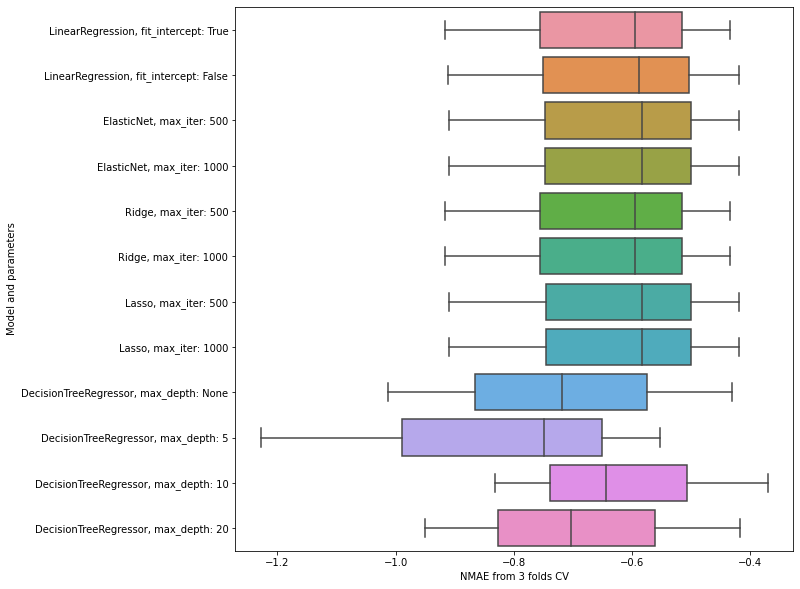

In [ ]:
plt.figure(figsize=(10,10))
results = pd.read_csv('exp1.csv', na_filter=False)

ax = sns.boxplot(data=results, y="parameters", x="score", orient="h")
ax.set(xlabel='NMAE from 3 folds CV', ylabel='Model and parameters')
plt.show()

In [ ]:
df = pd.read_pickle('time_series_minutes_window.pkl')

X = df.drop(['post_id', 't-0'], axis=1)
y = df['t-0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = False, stratify = None)

model = LinearRegression()

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mean_absolute_error(y_true=y_test,y_pred=y_pred)

0.47274098916989526

In [ ]:
df = pd.read_pickle('comments_with_time_diffrence.pkl')

print("Sample ids for tests")
df.submission_id.value_counts().nlargest(50)

Sample ids for tests


ladzdt    105754
l6ea1b    105249
l6er79    104523
l2ljpt    104143
l6u011     96690
l6y2hy     94517
l6vhy3     92053
l7ptxi     91360
l7iorh     89941
l7s631     89394
lb6aiq     86390
l7wqsm     86257
l7v9o8     85196
layuxv     82604
laujs5     82280
l71c4z     79191
l78za1     79107
la0n4z     77228
l9xqem     76402
l70sjp     75333
lat43j     74300
la5s8i     73739
l7ept4     73331
l68y04     72655
l81n15     69576
l9lvrn     68400
lab86a     68107
l8420s     66073
l692dj     65988
l747hb     65739
l6yhow     62537
l6o2gi     61570
lgrc39     61256
l80upw     58856
lh3qli     58044
l1xtan     57799
l6cb1x     56470
lbm3vr     51538
lbl62i     50415
la75n9     50368
l7kfrj     40695
l74zgc     39362
l68k3q     35912
lg0h70     34486
l6ci5r     33805
l84ner     33149
l170g4     28845
lflpoz     28814
l9wner     28453
lg0mn2     28203
Name: submission_id, dtype: int64

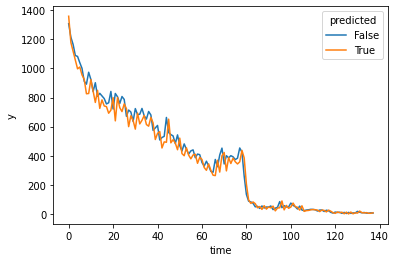

In [ ]:
df = pd.read_pickle('time_series_minutes_window.pkl')

post_id = 'lh3qli'

df = df.loc[df['post_id'] == post_id]

X = df.drop(['post_id', 't-0'], axis=1)
y = df['t-0']

y_pred = model.predict(X)

df1 = pd.DataFrame({'y': y, 'predicted': False}).reset_index(drop=True)
df2 = pd.DataFrame({'y': y_pred, 'predicted': True}).reset_index(drop=True)

df1['time'] = df1.index
df2['time'] = df2.index

df = pd.concat([df1, df2])

sns.lineplot(data=df, x="time", y="y", hue="predicted")

## Compare GameStop price with user engagement

In [ ]:
df = pd.read_csv('comments_raw.csv', na_filter=False)
df.shape

nine_hours = 60*60*9

df['created_utc'] = df['created_utc'] - nine_hours
df.sort_values(by=['created_utc'], inplace=True)

In [ ]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')
df_group = df.groupby(pd.Grouper(key='created_utc', freq='H')).count()
df_group.head(2)

,id,score,total_awards_received,submission_id
created_utc,,,,
2021-01-19 15:00:00,186,186,186,186
2021-01-19 16:00:00,364,364,364,364
2021-01-19 17:00:00,530,530,530,530
2021-01-19 18:00:00,467,467,467,467
2021-01-19 19:00:00,456,456,456,456
2021-01-19 20:00:00,445,445,445,445
2021-01-19 21:00:00,339,339,339,339
2021-01-19 22:00:00,304,304,304,304
2021-01-19 23:00:00,161,161,161,161


In [ ]:
df_gp = pd.read_csv('gamestonks.csv', na_filter=False)
df_gp['time'] = df_gp['time'].astype('datetime64')

df_gp.sort_values(by=['time'], inplace=True)
df_gp = df_gp.groupby(pd.Grouper(key='time', freq='H')).max()
df_gp.head(2)

,open,high,low,close,volume
time,,,,,
2020-12-23 08:00:00,21.43,21.50,21.24,21.43,9096.0
2020-12-23 09:00:00,20.94,20.95,20.94,20.95,5669.0


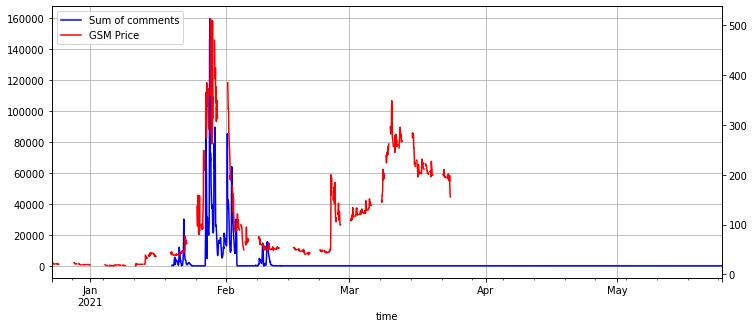

In [ ]:
plt.figure(figsize=(12,5))

ax1 = df_group.id.plot(color='blue', grid=True, label='Sum of comments')
ax2 = df_gp.high.plot(color='red', grid=True, secondary_y=True, label='GSM Price')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()


plt.legend(h1+h2, l1+l2, loc=2)
plt.show()